# Segmentación de datos de redes sociales.

En el archivo “snsdata.csv” se encuentra los términos más utilizados en unos 30.000 perfiles aleatorios de adolescentes de una red social. 
Voy a importar el archivo y separar el conjunto de datos en dos según el género de los usuarios (F y M). En cada uno de los subconjuntos de datos eliminaré el año de graduación ('gradyear'), el género ('gender') y la edad (‘age’). 

Utilizando el algoritmo de k-means identificaré el número de segmentos óptimos en los que se divide cada subconjunto de datos y obtendré los valores de los centroides.

In [1]:
import pandas as pd

datos = pd.read_csv('snsdata.csv', sep = ',') # importación de datos en un data frame de pandas

In [2]:
datos.head()

,gradyear,gender,age,friends,basketball,football,soccer,softball,volleyball,swimming,...,blonde,mall,shopping,clothes,hollister,abercrombie,die,death,drunk,drugs
0,2006,M,18.982,7,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2006,F,18.801,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,2006,M,18.335,69,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,2006,F,18.875,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2006,NaN,18.995,10,0,0,0,0,0,0,...,0,0,2,0,0,0,0,0,1,1


In [3]:
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 40 columns):
gradyear        30000 non-null int64
gender          27276 non-null object
age             24914 non-null float64
friends         30000 non-null int64
basketball      30000 non-null int64
football        30000 non-null int64
soccer          30000 non-null int64
softball        30000 non-null int64
volleyball      30000 non-null int64
swimming        30000 non-null int64
cheerleading    30000 non-null int64
baseball        30000 non-null int64
tennis          30000 non-null int64
sports          30000 non-null int64
cute            30000 non-null int64
sex             30000 non-null int64
sexy            30000 non-null int64
hot             30000 non-null int64
kissed          30000 non-null int64
dance           30000 non-null int64
band            30000 non-null int64
marching        30000 non-null int64
music           30000 non-null int64
rock            30000 non-null int64


Divido las observaciones de hombres y mujeres:

In [5]:
datos_F = datos[datos.gender == 'F']
datos_M = datos[datos.gender == 'M']

Elimino las tres primeras columnas:

In [15]:
datos_F.drop(datos_F.columns[[0,1,2]], axis=1, inplace=True)
datos_F.head()

C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


,tennis,sports,cute,sex,sexy,hot,kissed,dance,band,marching,...,blonde,mall,shopping,clothes,hollister,abercrombie,die,death,drunk,drugs
1,0,0,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,1,0,0,0,0,0,1,...,0,0,1,0,0,0,0,0,1,0
6,0,0,0,0,0,0,0,0,1,1,...,0,2,0,0,2,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
datos_M.drop(datos_M.columns[[0,1,2]], axis=1, inplace=True)
datos_M.head()

C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


,soccer,softball,volleyball,swimming,cheerleading,baseball,tennis,sports,cute,sex,...,blonde,mall,shopping,clothes,hollister,abercrombie,die,death,drunk,drugs
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
7,0,1,0,0,0,0,0,0,0,2,...,0,0,0,0,0,0,0,0,0,0
21,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
25,0,0,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


### Selección del número de clusters.

#### Método de evaluación de distorsión

Para optimizar el número de clusters observaré la dispersión entre los elementos de cada cluster. El punto en el que la dispersión deja de disminuir con aumento del número de clusters será el número óptimo.

In [31]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import cdist

#definición de la función de distorsión
def plot_distorsion(x, figure_name, max_k, n_init = 10):
    meandistortions = []

    for k in range(1, max_k):
        kmeans = KMeans(n_clusters = k, n_init = n_init).fit(x)
        meandistortions.append(sum(np.min(cdist(x, kmeans.cluster_centers_,
                                                'euclidean'), axis = 1))
                               / x.shape[0])

    plot(range(1, max_k), meandistortions, 'bx-')
    xlabel('k')
    ylabel('Distorsion promedio')
    title(figure_name)

Using matplotlib backend: Qt4Agg
Populating the interactive namespace from numpy and matplotlib


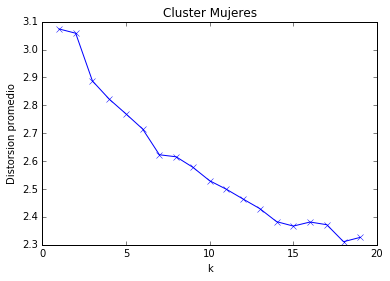

In [32]:
%pylab
%matplotlib inline

plot_distorsion(datos_F, "Cluster Mujeres", max_k=20) # Implementación para mujeres.

Observamos que en caso de las mujeres a partir de los 7 clustrers la pendiente cambia y la dispersión empieza a disminuir más lentamente. El siguiente punto de inflexión son 15 clusters, a partir de los que la distorsión aumenta.

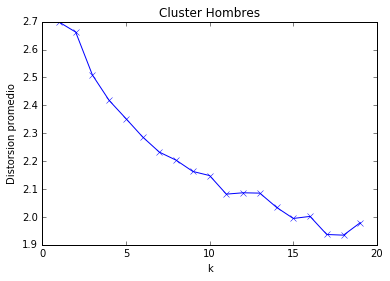

In [33]:
plot_distorsion(datos_M, "Cluster Hombres", max_k = 20)# implementación para hombres

En caso de los hombres la distorsión desciende rápidamente hasta los 5 clusters. A continuación la velocidad del descenso de la disperción baja ligeramente hasta los 11 clusters. A partir de los 11 clusters la mejora es menos visible.

#### Método de evaluación del coeficiente de Silhouette 

Este método evalua a distancia de separación entre clusters. Cuanto más separados los clusters mejor. Se comprueba el coeficiente de separación por cada número de clusters para poder elegir el número çoptimo.

In [34]:
from sklearn.metrics import silhouette_score

def plot_sillhouette(blobs, figure_name, max_k, n_init = 10):
    sillhouette_avgs = []
    
    for k in range(2, max_k):
        kmean = KMeans(n_clusters = k, n_init = n_init).fit(blobs)
        sillhouette_avgs.append(silhouette_score(blobs, kmean.labels_))
        
    plot(range(2, max_k), sillhouette_avgs)
    title(figure_name)

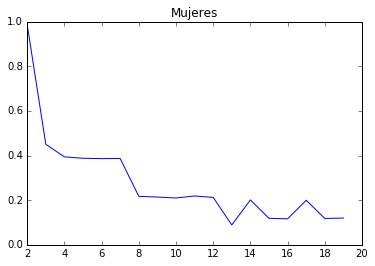

In [35]:
plot_sillhouette(datos_F, 'Mujeres',max_k = 20) # implementación para mujeres

En caso de las mujeres observamos que mayor grado de separación existe con 3 clusters y en segundo lugar con 7 clusters. A partir de los 13 clusters la separación empeora considerablemente.

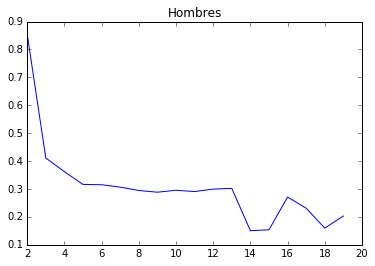

In [36]:
plot_sillhouette(datos_M, 'Hombres',max_k = 20)

En caso de los hombres el grado de separación desciende a partir de los 3 y 5 clusters. A partir de los 13 clusters empeora definitivamente.

Teniendo en cuenta el resultado del análisis de distorsión y del coeficiente de Silhouette dedido dividir los datos de las mujeres en 7 clusters y los datos de los hombres en 5 clusters. Es el número de clusters a partir del que dejo de obener una mejora considerable a costa de mas clusters.

En caso de querer obtener una división más fina el siguiente escalon serían 12 clusters para mujeres y 11 cluster para hombres.

#### Clusterisación

Divido las mujeres en 7 clusters.

In [37]:
kmeansF = KMeans(n_clusters = 7, n_init = 10).fit(datos_F)
kmeansF

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=7, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)

Puedo ver los centróides. Ellos reflejarían las características medias de cada cluster.

In [38]:
kmeansF.cluster_centers_

array([[  1.08536585e-01,   1.62195122e-01,   4.57317073e-01,
          1.81707317e-01,   1.58536585e-01,   1.81707317e-01,
          1.08536585e-01,   3.45121951e-01,   3.47560976e-01,
          3.90243902e-02,   8.40243902e-01,   2.92682927e-01,
          4.68048780e+00,   1.42439024e+00,   6.93902439e-01,
          1.46341463e-01,   4.80487805e-01,   1.76829268e-01,
          1.23170732e-01,   3.01219512e-01,   4.93902439e-01,
          2.30487805e-01,   5.48780488e-02,   5.12195122e-02,
          3.75609756e-01,   2.30487805e-01,   1.00000000e-01,
          6.34146341e-02],
       [  7.29040097e-02,   1.04943403e-01,   3.15789474e-01,
          1.01298203e-01,   1.34360811e-01,   1.25727441e-01,
          5.42943020e-02,   2.26577988e-01,   9.95715291e-02,
          1.44529002e-02,   3.27044830e-01,   1.47023086e-01,
          2.68401867e-01,   1.82451877e-01,   7.82758841e-02,
          1.17030121e-02,   2.71919166e-01,   9.84843640e-02,
          6.60612649e-02,   2.29711582e-01,

Puedo ver por que cada cluster tiene características medias diferentes:

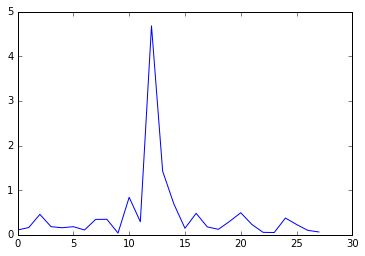

In [56]:
plot(kmeansF.cluster_centers_[0])

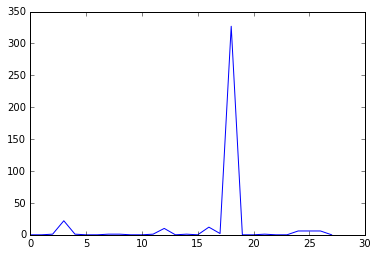

In [44]:
plot(kmeansF.cluster_centers_[2])

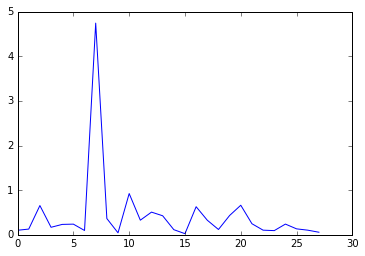

In [46]:
plot(kmeansF.cluster_centers_[3])

Divido los hombres en 6 clusters

In [58]:
kmeansM = KMeans(n_clusters = 6, n_init = 10).fit(datos_M)

In [59]:
kmeansM.cluster_centers_

array([[  2.13346815e-01,   5.56117290e-03,   3.33670374e-02,
          7.25480283e-02,   6.82507583e-03,   1.19059656e-01,
          9.42871587e-02,   1.69362993e-01,   6.16784631e-02,
          9.88372093e-02,   7.38119312e-02,   4.55005056e-02,
          3.28614762e-02,   1.49140546e-01,   1.56976744e-01,
          2.40141557e-02,   2.75025278e-01,   1.62032356e-01,
          2.00455005e-01,   1.46107179e-01,   6.97674419e-02,
          1.23862487e-02,   1.16531850e-01,   2.19919110e-02,
          1.49140546e-02,   1.05662285e-01,   4.19615774e-02,
          5.78867543e-02,   3.10920121e-02,   2.12335693e-02,
          1.40293225e-01,   7.50758342e-02,   6.16784631e-02,
          3.48837209e-02],
       [  2.36180905e-01,   1.63316583e-02,   4.64824121e-02,
          1.00502513e-01,   1.50753769e-02,   1.31909548e-01,
          1.31909548e-01,   2.71356784e-01,   1.01758794e-01,
          4.04522613e-01,   1.20603015e-01,   6.40703518e-02,
          1.54522613e-01,   4.73618090e-01,

También puedo ver que caracterñisticas de los clusters difieren:

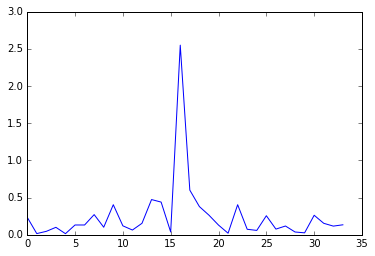

In [62]:
plot(kmeansM.cluster_centers_[1])

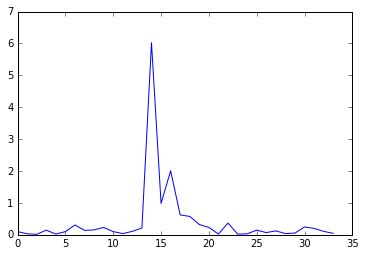

In [63]:
plot(kmeansM.cluster_centers_[2])

Alternativamente, dividiría de forma más fina en 12 y 11 clusters.

In [64]:
kmeansF_alt = KMeans(n_clusters = 12, n_init = 10).fit(datos_F) # clasificación alternativa mujeres
kmeansM_alt = KMeans(n_clusters = 11, n_init = 10).fit(datos_M) # clasificación alternativa hombres

In [65]:
kmeansF_alt.cluster_centers_

array([[  6.98336926e-02,   1.00169387e-01,   1.31583000e-01,
          8.94672005e-02,   1.22343702e-01,   1.05174007e-01,
          4.58885125e-02,   2.10886973e-01,   1.06020942e-01,
          1.63997536e-02,   3.28149061e-01,   1.40514321e-01,
          1.75084694e-01,   1.17031106e-01,   7.03726517e-02,
          9.16230366e-03,   1.83400062e-01,   8.06898676e-02,
          5.23560209e-02,   1.59454881e-01,   3.00200185e-01,
          9.13150601e-02,   5.42038805e-02,   3.90360333e-02,
          1.15414229e-01,   8.56174931e-02,   5.86695411e-02,
          2.39451802e-02],
       [  1.03910615e-01,   1.25139665e-01,   5.25139665e-01,
          1.94413408e-01,   2.27932961e-01,   2.44692737e-01,
          1.03910615e-01,   4.90614525e+00,   2.97206704e-01,
          2.90502793e-02,   9.16201117e-01,   3.37430168e-01,
          4.83798883e-01,   3.02793296e-01,   1.06145251e-01,
          2.45810056e-02,   5.91061453e-01,   3.16201117e-01,
          1.09497207e-01,   4.04469274e-01,

In [66]:
kmeansM_alt.cluster_centers_

array([[  9.75609756e-02,   6.96864111e-03,   4.18118467e-02,
          1.14982578e-01,   1.39372822e-02,   1.11498258e-01,
          1.60278746e-01,   1.39372822e-01,   6.27177700e-02,
          8.71080139e-02,   5.92334495e-02,   4.52961672e-02,
          3.83275261e-02,   1.32404181e-01,   3.12543554e+00,
          5.29616725e-01,   9.33797909e-01,   3.76306620e-01,
          4.07665505e-01,   2.12543554e-01,   1.01045296e-01,
          1.74216028e-02,   1.46341463e-01,   2.78745645e-02,
          2.09059233e-02,   8.71080139e-02,   6.96864111e-02,
          6.62020906e-02,   2.78745645e-02,   1.39372822e-02,
          1.28919861e-01,   1.60278746e-01,   8.36236934e-02,
          3.48432056e-02],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          4.00000000e-01,   0.00000000e+00,   6.00000000e-01,
          0.00000000e+00,   6.00000000e-01,   0.00000000e+00,
          4.00000000e-01,   2.00000000e-01,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,